In [1]:
import os
import cv2
import numpy as np
import torch
import os
import os.path as osp
from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt
from copy import deepcopy
from ultralytics.nn.modules.head import Detect
import coremltools as ct
import platform



SCALE = 1/255
BIAS = [0.0, 0.0, 0.0]
MODEL_PATH = 'orangeyolo.mlpackage'
CLASSES = {0: 'fresh orange', 1: 'rotten orange'}
MACOS, LINUX, WINDOWS = (platform.system() == x for x in ['Darwin', 'Linux', 'Windows'])  # environment booleans



class IOSDetectModel(torch.nn.Module):
    """Wrap an Ultralytics YOLO model for Apple iOS CoreML export."""

    def __init__(self, model, im):
        """Initialize the IOSDetectModel class with a YOLO model and example image."""
        super().__init__()
        _, _, h, w = im.shape  # batch, channel, height, width
        self.model = model
        self.nc = len(model.names)  # number of classes
        if w == h:
            self.normalize = 1.0 / w  # scalar
        else:
            self.normalize = torch.tensor([1.0 / w, 1.0 / h, 1.0 / w, 1.0 / h])  # broadcast (slower, smaller)

    def forward(self, x):
        """Normalize predictions of object detection model with input size-dependent factors."""
        xywh, cls = self.model(x)[0].transpose(0, 1).split((4, self.nc), 1)
        return cls, xywh * self.normalize  # confidence (3780, 80), coordinates (3780, 4)


# device = torch.device('mps')

config_path = 'plus640.yml'
model_path = 'savedir640/model_best/nanodet_model_best.pth'
image_path = 'orangecoco2/test/1004_jpg.rf.28748b1acd277ecefe74d18d204c51f3.jpg'

# im = torch.zeros(1, 3, 640, 640)
im = np.array(Image.open(image_path))
im = torch.tensor(im).unsqueeze(0).permute(0,3,1,2)/255.0

model = YOLO('best.pt')
export = model.export(format='coreml', nms=True)
exported_model = export.model




Ultralytics YOLOv8.0.209 🚀 Python-3.11.6 torch-2.1.0 CPU (Apple M1)
Model summary (fused): 168 layers, 3006038 parameters, 0 gradients

PyTorch: starting from 'best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 6, 8400) (5.9 MB)

CoreML: starting export with coremltools 7.1...
Tuple detected at graph output. This will be flattened in the converted model.
Running MIL backend_mlprogram pipeline: 100%|██████████| 12/12 [00:00<00:00, 854.45 passes/s]
CoreML Pipeline: starting pipeline with coremltools 7.1...
CoreML Pipeline: pipeline success
CoreML: export success ✅ 12.3s, saved as 'best.mlpackage' (5.9 MB)

Export complete (12.8s)
Results saved to /Users/mkhoatd/Developer/fruit
Predict:         yolo predict task=detect model=best.mlpackage imgsz=640  
Validate:        yolo val task=detect model=best.mlpackage imgsz=640 data=./data.yaml  
Visualize:       https://netron.app


In [ ]:
model.export(format='coreml', nms=True)

In [2]:
iosmodel = IOSDetectModel(model=exported_model, im=im)
iosmodel.eval()
ts = torch.jit.trace(iosmodel.eval(), im, strict=False)


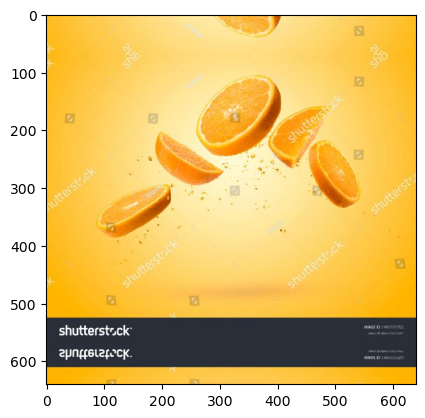

In [6]:
plt.imshow(im[0].permute(1,2,0))

In [8]:
im.shape

torch.Size([1, 3, 640, 640])

In [5]:
iosmodel(im)[1].shape

torch.Size([8400, 4])

In [6]:
ct_model = ct.convert(ts,
                      inputs=[ct.ImageType('image', shape=im.shape, scale=SCALE, bias=BIAS)],
                      classifier_config=None,
                      convert_to='mlprogram')
ct_model.save(MODEL_PATH)
weights_dir = str(osp.join(MODEL_PATH, 'Data/com.apple.CoreML/weights'))

spec = ct_model.get_spec()
out0, out1 = iter(spec.description.output)
out0_shape = out0.type.multiArrayType.shape
out1_shape = out1.type.multiArrayType.shape

Tuple detected at graph output. This will be flattened in the converted model.
Running MIL backend_mlprogram pipeline: 100%|██████████| 12/12 [00:00<00:00, 545.31 passes/s]


In [7]:
out0_shape

[8400, 2]

In [76]:
ct_model = ct.convert(ts,
                      inputs=[ct.ImageType('image', shape=im.shape, scale=SCALE, bias=BIAS)],
                      classifier_config=None,
                      convert_to='mlprogram')
ct_model.save(MODEL_PATH)
weights_dir = str(osp.join(MODEL_PATH, 'Data/com.apple.CoreML/weights'))

spec = ct_model.get_spec()
out0, out1 = iter(spec.description.output)
out0_shape = out0.type.multiArrayType.shape
out1_shape = out1.type.multiArrayType.shape

nx, ny = spec.description.input[0].type.imageType.width, spec.description.input[0].type.imageType.height
_, nc = out0_shape

cm_from_spec = ct.models.MLModel(spec, weights_dir=weights_dir)
nms_spec = ct.proto.Model_pb2.Model()
nms_spec.specificationVersion = 5
for i in range(2):
    decoder_output = cm_from_spec._spec.description.output[i].SerializeToString()
    nms_spec.description.input.add()
    nms_spec.description.input[i].ParseFromString(decoder_output)
    nms_spec.description.output.add()
    nms_spec.description.output[i].ParseFromString(decoder_output)

nms_spec.description.output[0].name = 'confidence'
nms_spec.description.output[1].name = 'coordinates'

output_sizes = [nc, 4]
for i in range(2):
    ma_type = nms_spec.description.output[i].type.multiArrayType
    ma_type.shapeRange.sizeRanges.add()
    ma_type.shapeRange.sizeRanges[0].lowerBound = 0
    ma_type.shapeRange.sizeRanges[0].upperBound = -1
    ma_type.shapeRange.sizeRanges.add()
    ma_type.shapeRange.sizeRanges[1].lowerBound = output_sizes[i]
    ma_type.shapeRange.sizeRanges[1].upperBound = output_sizes[i]
    del ma_type.shape[:]

nms = nms_spec.nonMaximumSuppression
nms.confidenceInputFeatureName = out0.name  # 1x507x80
nms.coordinatesInputFeatureName = out1.name  # 1x507x4
nms.confidenceOutputFeatureName = 'confidence'
nms.coordinatesOutputFeatureName = 'coordinates'
nms.iouThresholdInputFeatureName = 'iouThreshold'
nms.confidenceThresholdInputFeatureName = 'confidenceThreshold'
nms.iouThreshold = 0.45
nms.confidenceThreshold = 0.25
nms.pickTop.perClass = True
nms.stringClassLabels.vector.extend(CLASSES.values())
nms_model = ct.models.MLModel(nms_spec)

# 4. Pipeline models together
pipeline = ct.models.pipeline.Pipeline(input_features=[('image', ct.models.datatypes.Array(3, ny, nx)),
                                                       ('iouThreshold', ct.models.datatypes.Double()),
                                                       ('confidenceThreshold', ct.models.datatypes.Double())],
                                       output_features=['confidence', 'coordinates'])
pipeline.add_model(cm_from_spec)
pipeline.add_model(nms_model)

# Correct datatypes
pipeline.spec.description.input[0].ParseFromString(cm_from_spec._spec.description.input[0].SerializeToString())
pipeline.spec.description.output[0].ParseFromString(nms_model._spec.description.output[0].SerializeToString())
pipeline.spec.description.output[1].ParseFromString(nms_model._spec.description.output[1].SerializeToString())

# Update metadata
pipeline.spec.specificationVersion = 5
pipeline.spec.description.metadata.userDefined.update({
    'IoU threshold': str(nms.iouThreshold),
    'Confidence threshold': str(nms.confidenceThreshold)})

# Save the model
model_from_pipeline_spec = ct.models.MLModel(pipeline.spec, weights_dir=weights_dir)
model_from_pipeline_spec.input_description['image'] = 'Input image'
model_from_pipeline_spec.input_description['iouThreshold'] = f'(optional) IOU threshold override (default: {nms.iouThreshold})'
model_from_pipeline_spec.input_description['confidenceThreshold'] = \
    f'(optional) Confidence threshold override (default: {nms.confidenceThreshold})'
model_from_pipeline_spec.output_description['confidence'] = 'Boxes × Class confidence (see user-defined metadata "classes")'
model_from_pipeline_spec.output_description['coordinates'] = 'Boxes × [x, y, width, height] (relative to image size)'


Tuple detected at graph output. This will be flattened in the converted model.
Running MIL backend_mlprogram pipeline: 100%|██████████| 12/12 [00:00<00:00, 728.16 passes/s]


In [78]:
model_from_pipeline_spec.predict({"image": Image.open(image_path)})

{'coordinates': array([[    0.77783,     0.43164,     0.13477,     0.18433],
        [    0.52002,     0.27637,     0.22534,     0.21875],
        [    0.23926,     0.53564,     0.20557,     0.14612],
        [    0.54492,    0.029968,     0.19958,    0.061279],
        [     0.3877,     0.38452,     0.19189,     0.15576],
        [    0.68799,     0.33276,     0.17102,     0.16418]], dtype=float32),
 'confidence': array([[    0.83105,           0],
        [    0.80957,   0.0029297],
        [    0.78516,  0.00097656],
        [    0.73926,  0.00097656],
        [    0.73633,           0],
        [    0.66797,  0.00097656]], dtype=float32)}

In [80]:
model_from_pipeline_spec.save(MODEL_PATH)